# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import

In [66]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

# Loading the training data
y, tX, ids = load_csv_data('data/train.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preprocessing

### Undefined values visualization

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0]


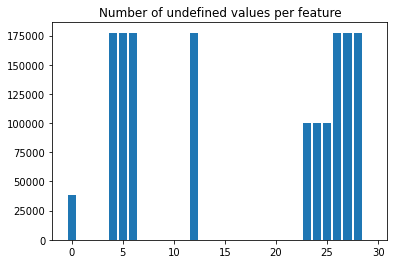

[15.2456  0.      0.      0.     70.9828 70.9828 70.9828  0.      0.
  0.      0.      0.     70.9828  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.     39.9652 39.9652 39.9652 70.9828
 70.9828 70.9828  0.    ]


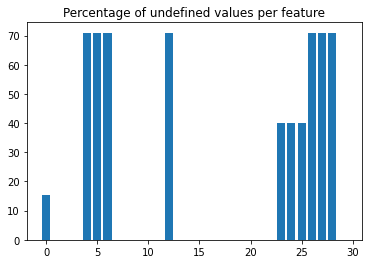

72.7544


In [82]:
#Counting the number of undefined values and the percentage of undefined values
counter = np.sum((tX == -999), axis = 0)
print(counter)
undef_ind = np.nonzero(counter)[0]
plt.bar(np.arange(len(counter)), counter)
plt.title("Number of undefined values per feature") 
plt.show()

#Percentage of undefined values
N = tX.shape[0]
rel_counter = counter / N * 100 
print(rel_counter)
plt.bar(np.arange(len(rel_counter)), rel_counter)
plt.title("Percentage of undefined values per feature") 
plt.show()

#Counting the percentage of inputs with at least one undefined feature 
counter = np.sum((tX == -999), axis = 1)
tot = np.count_nonzero(counter)
print(tot / N * 100)

Notes:
* Same number of undefined features for some features. This are structurally missing features.
* Very high percentage for some particular features.

### Dataset splitting

In [14]:
# Splitting dataset into train and validation sets
ratio = 0.8  # Ratio of samples to use in new train set
cut_off_point = int(ratio*len(y))
np.random.seed(0)  # Fixing a seed for reproducibility
rand_ind = np.random.permutation(np.arange(len(y)))
y_train, y_valid = y[cut_off_point:], y[:cut_off_point]
tX_train, tX_valid = tX[cut_off_point:], tX[:cut_off_point]

### Replacing undefined entries

In [91]:
#Replacing undefined entrance:
tX_train_nan = np.where(tX_train != 999, tX_train, np.nan)
tX_valid_nan = np.where(tX_valid != 999, tX_valid, np.nan)

#1. With zero entries
tX_train_zeros = np.where(tX_train_nan != np.nan, tX_train_nan, 0)
tX_valid_zeros = np.where(tX_valid_nan != np.nan, tX_valid_nan, 0) 
tX_train_zeros = standardize(tX_train_zeros)
tX_valid_zeros = standardize(tX_valid_zeros)


#2. With mean
mu_train = np.nanmean(tX_train_nan, axis = 0)
tX_train_mean = np.where(tX_train_nan != np.nan, tX_train_nan, mu_train)
tX_train_mean = standardize(tX_train_mean)
mu_valid = np.nanmean(tX_valid_nan, axis = 0)
tX_valid_mean = np.where(tX_valid_nan != np.nan, tX_valid_nan, mu_valid)
tX_valid_mean = standardize(tX_valid_mean)

#3. With median
mu_train = np.nanmedian(tX_train_nan, axis = 0)
tX_train_median = np.where(tX_train_nan != np.nan, tX_train_nan, mu_train)
tX_train_median = standardize(tX_train_median)
mu_valid = np.nanmedian(tX_valid_nan, axis = 0)
tX_valid_median = np.where(tX_valid_nan != np.nan, tX_valid_nan, mu_valid)
tX_valid_median = standardize(tX_valid_median)

#4. Adding a binary variable
tX_train_binary = np.hstack((tX_train, (2*np.isnan(tX_train_nan[:, undef_ind]) - 1)))
tX_train_binary = standardize(tX_train_binary)
tX_valid_binary = np.hstack((tX_valid, (2*np.isnan(tX_valid_nan[:, undef_ind]) - 1)))
tX_valid_binary = standardize(tX_valid_binary)


# Standardizing the data
tX_train = standardize(tX_train)
tX_valid = standardize(tX_valid)

# Creating a dictionary of traning and validation sets
train_dict = {'normal': tX_train, 'zeros': tX_train_zeros, 'mean': tX_train_mean, 'median': tX_train_median, 'binary': tX_train_binary}
valid_dict = {'normal': tX_valid, 'zeros': tX_valid_zeros, 'mean': tX_valid_mean, 'median': tX_valid_median, 'binary': tX_valid_binary}



         Only standardized this one with the feature-mean.
         Only standardized this one with the feature-mean.


## Visualizations

In [7]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

In [8]:
print(y.shape, tX.shape, ids.shape)
data = pd.read_csv('data/train.csv')
data.head(5)

(250000,) (250000, 30) (250000,)


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [9]:
data.describe()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


### Correlation Matrix

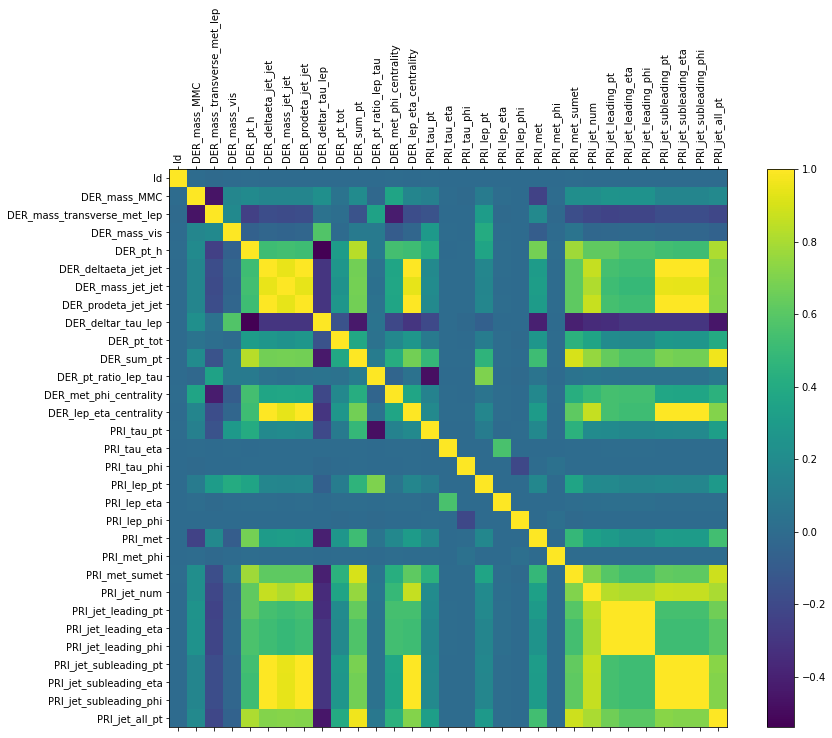

In [10]:
f = plt.figure(figsize=(14, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns)
cb = plt.colorbar()

### Get the most important features

In [11]:
model = ExtraTreesClassifier()
model.fit(tX,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_)
feat_importances.plot(kind='bar')
plt.show()

KeyboardInterrupt: 

Visualize feature correlation

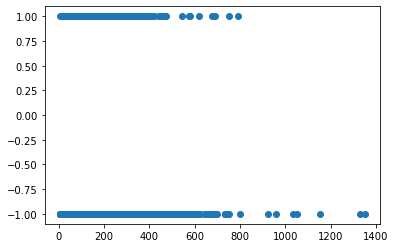

In [ ]:
x = data['DER_mass_vis'] #enter any feature to check for correlation to label.
plt.scatter(x, y) 
plt.plot()
plt.show()

Visualization of the predictions to show if the data set is balanced. Since we have a slightly unbalanced dataset we will evaluate the performance with the F1-Score which is a more telling method for evaluation.

Ratio: 0.521


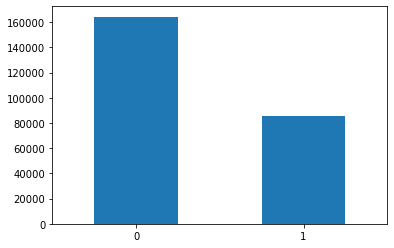

In [ ]:
count = collections.Counter(y)
balance = [count[-1], count[1]]
vis = pd.Series(balance, index=range(len(balance)))
vis.plot(kind="bar", rot=0)
plt.plot()
print("Ratio:", round(count[1]/count[-1],3))

## Scoring functions

In [3]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for 'Precision and recall'
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for 'F-score'
        https://en.wikipedia.org/wiki/F-score

    """

    # Number of samples
    N = len(y_valid)

    # Obtaining the predictions
    y_pred = predict_labels(weights, tX_valid)

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)

    f1 = np.round(2 * precision * recall / (precision + recall), 4)

    return f1

In [4]:
def accuracy(y_valid, tX_valid, weights):
    """
    Return the accuracy achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    acc : float
        Accuracy for this configuration (the closer to 1 the better)

    References
    ----------
    [3] Wikipedia entry for 'Accuracy and precision'
        https://en.wikipedia.org/wiki/Accuracy_and_precision

    """

    # Number of samples
    N = len(y_valid)

    # Obtaining the predictions
    y_pred = predict_labels(weights, tX_valid)

    # Calculating number of true positives and negatives
    num_tp_tn = np.sum(y_valid == y_pred)

    acc = np.round(num_tp_tn / N, 4)

    return acc

## Hyperparameter tuning

In [5]:
def cross_validate(regressor, y, tX, param, k_fold, score='f1'):
    """
    'k_fold' cross validate a regressor with parameters 'param', data '(y, TX)' 
    and score the predictions with 'score'
    """
    
    N = len(y)
    fold_size = int(N / k_fold)

    scores = []

    rand_ind = np.random.permutation(np.arange(N))

    for k in range(k_fold):

        # Splitting data set into validation and training set (for current fold)
        valid_ind = rand_ind[k*fold_size:(k+1)*fold_size]

        tX_train, y_train = tX[valid_ind], y[valid_ind]
        tX_valid, y_valid = np.delete(tX, valid_ind, axis=0), np.delete(y, valid_ind, axis=0)

        # Fitting/scoring regressor with the tarining/validation set
        weights, _ = eval(regressor)(y_train, tX_train, **param)
        
        # Scoring according to the scoring criterion
        if score == 'f1':

            scores.append(f1_score(y_valid, tX_valid, weights))

        else:

            scores.append(accuracy(y_valid, tX_valid, weights))

    # Returning mean and standard deviation of the scores
    return np.mean(scores), np.std(scores, ddof=1)

In [10]:
def best_parameters(regressor, y, tX, params, k_fold, score):
    """
    Find best parameters from a list of parameters with k_fold cross validation.
    """

    max_std_score = 0.0
    max_mean_score = 0.0
    max_param = {}

    for param in params:

        mean_score, std_score = cross_validate(regressor, y, tX, param, k_fold, score)

        # Checking for the best score
        if mean_score > max_mean_score:

            max_mean_score = mean_score
            max_std_score = std_score
            max_param = param

    print("Best parameter set for '", regressor, "' was:")
    print("param = ", max_param)
    print("Mean ", score, " score: ", max_mean_score, " +/- ", max_std_score)


### Gradient descent

In [73]:
for degree in range(1, 8):

    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)

    params = [{'initial_w': np.ones(tX_poly.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.02, 0.1, 5), np.linspace(1000, 5000, 5, dtype=int))]

    best_parameters('least_squares_GD', y, tX_poly, params, k_fold=4, score='f1')
    print("---------------------------------------------------")


Result for degree  1
Best parameter set for ' least_squares_GD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 4000, 'gamma': 0.08}
[Mean  f1  score:  0.665  +/-  0.00116045967903529
---------------------------------------------------
Result for degree  2


<ipython-input-3-553fcfad640a>:39: RuntimeWarning: invalid value encountered in long_scalars
  precision = num_tp / (num_tp + num_fp)
<ipython-input-3-553fcfad640a>:40: RuntimeWarning: invalid value encountered in long_scalars
  recall = num_tp / (num_tp + num_fn)


Best parameter set for ' least_squares_GD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 3000, 'gamma': 0.06}
[Mean  f1  score:  0.6756249999999999  +/-  0.0009708243919473789
---------------------------------------------------
Result for degree  3
Best parameter set for ' least_squares_GD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 'max_iter

c:\Users\Fabio\Documents\ML_project1\implementations.py:365: RuntimeWarning: overflow encountered in square
  loss = np.mean(e**2) / 2


Best parameter set for ' least_squares_GD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 1000, 'gamma': 0.02}
[Mean  f1  score:  0.6742250000000001  +/-  0.0013889444433333906
-----------------------------

### Stochastic gradient descent

In [68]:
for degree in range(1, 8):

    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)

    params = [{'initial_w': np.ones(tX_poly.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.001, 0.1, 100), np.linspace(1000, 10000, 10, dtype=int))]

    best_parameters('least_squares_SGD', y, tX_poly, params, k_fold=4, score='f1')
    print("---------------------------------------------------")


Result for degree  1
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 10000, 'gamma': 0.010000000000000002}
[Mean  f1  score:  0.45667499999999994  +/-  0.0005123475382979669
---------------------------------------------------
Result for degree  2
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 1000, 'gamma': 0.001}
[Mean  f1  score:  0.404675  +/-  0.0005909032633745411
---------------------------------------------------
Result for degree  3
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w':

### Least squares

In [71]:
for degree in range(1, 8):

    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)

    print(cross_validate('least_squares', y, tX_poly, {}, k_fold=4, score='f1'))
    print("---------------------------------------------------")


Result for degree  1
(0.6648, 0.0009486832980505146)
---------------------------------------------------
Result for degree  2
(0.6798500000000001, 0.0007724420150837417)
---------------------------------------------------
Result for degree  3
(0.6807, 0.0038635044540761957)
---------------------------------------------------
Result for degree  4
(0.6706, 0.01487884404112091)
---------------------------------------------------
Result for degree  5
(0.6873, 0.014738385257551096)
---------------------------------------------------
Result for degree  6
(0.69045, 0.0042154477816715875)
---------------------------------------------------
Result for degree  7
(0.6754749999999999, 0.03813016085288213)
---------------------------------------------------


### Ridge regressor

In [57]:
params = [{'lambda_': lambda_} for lambda_ in np.linspace(0.00001, 0.0001, 10)]

for degree in range(1, 8):

    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)

    best_parameters('ridge_regression', y, tX_poly, params, k_fold=4, score='f1')
    print("---------------------------------------------------")

Result for degree  1
Best parameter set for ' ridge_regression ' was:
param =  {'lambda_': 5e-05}
[Mean  f1  score:  0.6651  +/-  0.000828653526310415
---------------------------------------------------
Result for degree  2
Best parameter set for ' ridge_regression ' was:
param =  {'lambda_': 4e-05}
[Mean  f1  score:  0.67585  +/-  0.0015588457268120057
---------------------------------------------------
Result for degree  3
Best parameter set for ' ridge_regression ' was:
param =  {'lambda_': 3.0000000000000004e-05}
[Mean  f1  score:  0.67875  +/-  0.00036968455021366657
---------------------------------------------------
Result for degree  4
Best parameter set for ' ridge_regression ' was:
param =  {'lambda_': 1e-05}
[Mean  f1  score:  0.6875249999999999  +/-  0.0017914147109663779
---------------------------------------------------
Result for degree  5
Best parameter set for ' ridge_regression ' was:
param =  {'lambda_': 2e-05}
[Mean  f1  score:  0.690725  +/-  0.0016820126832656752

### Logistic regressor

In [34]:
params = [{'initial_w': np.ones(tX.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.001, 0.01, 10), np.linspace(100, 1000, 10, dtype=int))]

best_parameters('logistic_regression', y, tX, params, k_fold=4, score='f1')

Best parameter set for ' logistic_regression_alt ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 1000, 'gamma': 0.01}
[Mean  f1  score:  0.6023000000000001  +/-  0.012697768832882948


### Regularized logistic regressor

In [35]:
params = [{'lambda_' : lambda_, 'initial_w': np.ones(tX.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for lambda_, gamma, max_iters in zip(np.linspace(0.01, 0.1, 10), np.linspace(0.01, 0.1, 10), np.linspace(100, 1000, 10, dtype=int))]

best_parameters('reg_logistic_regression', y, tX, params, k_fold=4, score='f1')

Best parameter set for ' reg_logistic_regression ' was:
param =  {'lambda_': 0.01, 'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 100, 'gamma': 0.01}
[Mean  f1  score:  0.44599999999999995  +/-  0.0008679477710861177


## Regressors

### 1. Least squares gradient descent

In [15]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 1300
gamma = 0.013

# Fitting
start = time.time()
weights, loss = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_GD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_GD': accuracy = ", acc)

Execution time: 2.4335 sec
F1-score achieved with 'least_squares_GD': F1 =  0.6656
Accuracy achieved with 'least_squares_GD': accuracy =  0.718


 ### 2. Least squares stochastic gradient descent

In [23]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 9800
gamma = 0.098

# Fitting
start = time.time()
weights, loss = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_SGD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_SGD': accuracy = ", acc)

Execution time: 0.0599 sec
F1-score achieved with 'least_squares_SGD': F1 =  0.4579
Accuracy achieved with 'least_squares_SGD': accuracy =  0.598


### 3. Least squares (normal equation)

In [24]:
# Fitting
start = time.time()
weights, loss = least_squares(y_train, tX_train)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares': F1 = ", f1)
print("Accuracy achieved with 'least_squares': accuracy = ", acc)

Execution time: 0.003 sec
F1-score achieved with 'least_squares': F1 =  0.6656
Accuracy achieved with 'least_squares': accuracy =  0.7186


### 4. Ridge regression (for least square normal equation)

In [39]:
# Hyperparameters
lambda_ = 0.0051

# Fitting
start = time.time()
weights, loss = ridge_regression(y_train, tX_train_binary, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid_binary, weights)
acc = accuracy(y_valid, tX_valid_binary, weights)
print("F1-score achieved with 'ridge_regression': F1 = ", f1)
print("Accuracy achieved with 'ridge_regression': accuracy = ", acc)

Execution time: 0.002 sec
F1-score achieved with 'ridge_regression': F1 =  0.6656
Accuracy achieved with 'ridge_regression': accuracy =  0.7174


### 5. Logistic regression

In [ ]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression': accuracy = ", acc)

Execution time: 1.5215 sec
F1-score achieved with 'logistic_regression': F1 =  0.4461
Accuracy achieved with 'logistic_regression': accuracy =  0.6041


### 5: Logistic regression (alternative)

In [29]:
def calculate_sigmoid(z):
    return 1/(1 + np.exp(-z))

In [30]:
def calculate_cost(y, tX, w):
    return 1/2 * np.sum((y-calculate_sigmoid(np.dot(tX, w)))**2)

In [31]:
def calculate_gradient(y, tX, w):   
    return np.dot(y-calculate_sigmoid(np.dot(tX, w)), tX)

In [32]:
def logistic_regression_alt(y, tX, initial_w, max_iters=100, gamma=0.01):
    w = initial_w
    loss = []
    for i in range(max_iters):
        random =  np.random.randint(0, len(y))
        w = w + gamma * calculate_gradient(y[random], tX[random], w)
        cost = calculate_cost(y, tX, w)
        loss.append(cost)
    return w, loss

In [ ]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression_alt(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression_alt': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression_alt': accuracy = ", acc)

Execution time: 0.814 sec
F1-score achieved with 'logistic_regression_alt': F1 =  0.4869
Accuracy achieved with 'logistic_regression_alt': accuracy =  0.5978


### 6. Regularized logistic regression

In [ ]:
# Hyperparameters
# TODO: test different values of gamma and lambda
lambda_ = 1
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'reg_logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'reg_logistic_regression': accuracy = ", acc)

Execution time: 1.4654 sec
F1-score achieved with 'reg_logistic_regression': F1 =  0.4418
Accuracy achieved with 'reg_logistic_regression': accuracy =  0.6044


## Preprocessing testing

In [95]:
lambda_ = 0.001
for key in train_dict:
    weights, loss = ridge_regression(y_train, train_dict[key], lambda_)
    f1 = f1_score(y_valid, valid_dict[key], weights)
    acc = accuracy(y_valid, valid_dict[key], weights)
    print("F1-score achieved with 'ridge_regression', dataset ", key, " : F1 = ", f1)
    print("Accuracy achieved with 'ridge_regression', dataset ", key, " : accuracy = ", acc)
    

F1-score achieved with 'ridge_regression', dataset  normal  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  normal  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  zeros  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  zeros  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  mean  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  mean  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  median  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  median  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  binary  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  binary  : accuracy =  0.718


## Optimized Regressors

In [ ]:
def f1_score_predictions(y_valid, y_pred):
    """
    Return the F1-score achieved with the predictions of a validation set
    
    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    y_pred : np.ndarray
        Vector containing the predictions.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for the Precision and recall
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for F-score
        https://en.wikipedia.org/wiki/F-score

    """

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)

    f1 = np.round(2 * precision * recall / (precision + recall),4)
    
    return f1

### Ensemble learner 1

In [ ]:
def ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    features. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_features = tX.shape[1]

    for i in range(n_learners):

        feature_indices = np.random.choice(np.arange(n_features), int(ratio*n_features))
        tX_slice = tX[:, feature_indices]
        weights, _ = reg_logistic_regression(y, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        tX_valid_slice = tX_valid[:, feature_indices]
        y_pred = tX_valid_slice @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [ ]:
# Fitting
start = time.time()
y_pred = ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.3)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 10.773 sec
F1-score achieved with 'logistic_regression': F1 =  0.4296


### Ensemble learner 2

In [ ]:
def ensemble_learner2(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    samples. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_samples = tX.shape[0]

    for i in range(n_learners):

        sample_indices = np.random.choice(np.arange(n_samples), int(ratio*n_samples))
        tX_slice = tX[sample_indices, :]
        y_slice = y[sample_indices]
        weights, _ = reg_logistic_regression(y_slice, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        y_pred = tX_valid @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [ ]:
# Fitting
start = time.time()
y_pred = ensemble_learner2(y, tX, tX_valid, n_learners=100, ratio=0.1)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 8.2593 sec
F1-score achieved with 'logistic_regression': F1 =  0.4418


### Evaluation

In [ ]:
y_pred = predict_labels(weights, tX_valid)
confusion_matrix(y_valid, y_pred)

array([[89563, 41933],
       [37196, 31308]], dtype=int64)

## Lasso subgradient descent regressor

In [37]:
def lasso_SD(y, tX, initial_w, max_iters=1000, gamma=0.1, lambda_ = 0.1, threshold=None):

    # Number of samples
    N = len(y)

    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))

    # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
    if len(tX.shape) == 1:

        tX = tX.reshape((N, 1))

    for iter in range(max_iters):

        # Error vector
        e = y - np.dot(tX, w)

        # Subgradient for the Lasso loss function
        subgrad = - np.dot(tX.T, e) / N + lambda_ / np.sqrt(1 + iter) * np.sign(w)

        # Updating weights with negative gradient scaled by 'gamma'
        w = w - gamma * subgrad


    # Computing loss (MSE) for the weights in the final iteration
    loss = np.mean(e**2) / 2

    # Converting weights back to 1D arrays
    w = w.reshape(len(w))

    # Setting to zero all the entries of w under the threshold in absolute value
    if (threshold != None):
        w[np.absolute(w) < threshold] = 0

    return w, loss

In [38]:
# Hyperparameters
# TODO: test different values of gamma and lambda
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1
lambda_ = 0.01
threshold = 0.005

# Fitting and scoring WITHOUT threshold
start = time.time()
weights, loss = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(weights)
print(np.sort(abs(weights)))

f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'lasso_GD', no threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', no threshold: accuracy = ", acc, "\n\n")

# Fitting and scoring WITH threshold
start = time.time()
weights_thresh, loss_thresh = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_, threshold)

exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(weights_thresh)
f1 = f1_score(y_valid, tX_valid, weights_thresh)
acc = accuracy(y_valid, tX_valid, weights_thresh)
print("F1-score achieved with 'lasso_GD', with threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', with threshold: accuracy = ", acc, "\n\n")

# Adding a polynomial basis of all the features
degree = 7
poly_tX_tr = standardize(polynomial_basis(tX_train, degree))
poly_tX_va = standardize(polynomial_basis(tX_valid, degree))
initial_w = np.zeros(poly_tX_tr.shape[1])

start = time.time()
weights_poly, loss_poly = lasso_SD(y_train, poly_tX_tr, initial_w, max_iters, gamma, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
#print(weights_poly)
f1 = f1_score(y_valid, poly_tX_va, weights_poly)
acc = accuracy(y_valid, poly_tX_va, weights_poly)
print("F1-score achieved with 'lasso_GD', polynomial basis: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', polynomial basis: accuracy = ", acc)



Execution time: 0.3358 sec
[ 3.47842299e-02 -2.45486121e-01 -2.49166126e-01 -6.91121217e-03
 -2.64669884e-02  4.15181967e-01 -3.58118715e-02  2.65605003e-01
 -4.47530287e-05 -1.09882499e-01 -1.75767915e-01  1.09968831e-01
 -2.82388222e-02  2.02186350e-01  4.36742603e-03  1.74872663e-03
  2.87739223e-01 -5.10187538e-03  8.72582347e-03  1.13936113e-01
  7.30771870e-03 -7.43113893e-02 -1.88111803e-01  2.39530474e-02
  6.17928993e-02  6.42323025e-02 -2.06132987e-02 -2.93818928e-02
 -3.00102528e-02 -1.62947323e-02]
[4.47530287e-05 1.74872663e-03 4.36742603e-03 5.10187538e-03
 6.91121217e-03 7.30771870e-03 8.72582347e-03 1.62947323e-02
 2.06132987e-02 2.39530474e-02 2.64669884e-02 2.82388222e-02
 2.93818928e-02 3.00102528e-02 3.47842299e-02 3.58118715e-02
 6.17928993e-02 6.42323025e-02 7.43113893e-02 1.09882499e-01
 1.09968831e-01 1.13936113e-01 1.75767915e-01 1.88111803e-01
 2.02186350e-01 2.45486121e-01 2.49166126e-01 2.65605003e-01
 2.87739223e-01 4.15181967e-01]
F1-score achieved with 'l

<ipython-input-3-553fcfad640a>:39: RuntimeWarning: invalid value encountered in long_scalars
  precision = num_tp / (num_tp + num_fp)
<ipython-input-3-553fcfad640a>:40: RuntimeWarning: invalid value encountered in long_scalars
  recall = num_tp / (num_tp + num_fn)


## Mean Absolute Error subgradient regressor

In [ ]:
def absolute_SD(y, tX, initial_w, max_iters=100, gamma=0.1):

    # Number of samples
    N = len(y)

    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))

    # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
    if len(tX.shape) == 1:

        tX = tX.reshape((N, 1))

    for iter in range(max_iters):

        # Error vector
        e = y - np.dot(tX, w)

        # Subgradient for the MAE loss function
        subgrad = - np.dot(tX.T, np.sign(e)) / N

        # Updating weights with negative gradient scaled by 'gamma'
        w = w - gamma * subgrad


    # Computing loss (MSE) for the weights in the final iteration
    loss = np.mean(np.abs(e))

    # Converting weights back to 1D arrays
    w = w.reshape(len(w))

    return w, loss

In [ ]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1

# Fitting
start = time.time()
weights, loss = absolute_SD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'absolute_SD': F1 = ", f1)
print("Accuracy achieved with 'absolute_GD': accuracy = ", acc)

Execution time: 0.415 sec
F1-score achieved with 'absolute_SD': F1 =  0.6386
Accuracy achieved with 'absolute_GD': accuracy =  0.7008


## Generate predictions and save ouput in csv format for submission

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

OSError:  not found.

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)